# Customer Behavior Analysis

## Import Useful Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import configparser
import os
from datetime import datetime

from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col, from_unixtime
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, dayofweek, date_format
from pyspark.sql.functions import min, max
from pyspark.sql.types import StructType, StructField as Fld, DoubleType as Dbl, StringType as Str, IntegerType as Int, DateType as Date, TimestampType as Ts, DecimalType as Deci, FloatType as Float
from pyspark.sql.window import Window

## Load Data from .csv File

In [2]:
# create spark session
spark = SparkSession.builder\
    .appName("spark_new")\
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

# create schema
schema = StructType([
    Fld("user_id", Int(), False),
    Fld("item_id", Int(), True),
    Fld("category_id", Int(), True),
    Fld("behavior_type", Str(), True),
    Fld("timestamps", Int(), True),
])

# read data from csv file
df = spark.read.csv('/home/zihe/work/UserBehavior.csv', schema=schema)#.limit(100000)
# memorize!

## Conduct Data Cleaning and Data Transformation

In [3]:
## drop rows with none values
df = df.na.drop().dropDuplicates()
## drop duplicate values
df = df.dropDuplicates()
## Convert Unix timestamp to a human-readable date format
df = df.withColumn("formatted_date", from_unixtime("timestamps"))
## add columns of year, month, and day
df = df.withColumn("date", date_format("formatted_date", "yyyy-MM-dd"))
df = df.withColumn("time", date_format("formatted_date", "HH:mm:ss"))
df = df.withColumn("hour", date_format("formatted_date", "HH"))

In [4]:
## Detecting and Treating Outlierss
## check outliers
max_datetime = df.agg(F.max("formatted_date")).collect()[0][0]
min_datetime = df.agg(F.min("formatted_date")).collect()[0][0]
print(f"Max Datetime: {max_datetime}")
print(f"Min Datetime: {min_datetime}")

Max Datetime: 2037-04-09 05:22:35
Min Datetime: 1902-05-07 22:32:46


In [5]:
## delete outliers
df = df.filter(
    (col("formatted_date") >= '2017-11-25 00:00:00') & (col("formatted_date") <= '2017-12-03 23:59:59')
)
df.cache()

DataFrame[user_id: int, item_id: int, category_id: int, behavior_type: string, timestamps: int, formatted_date: string, date: string, time: string, hour: string]

In [6]:
# basic information
df.show()
row_count = df.count()
print("Number of rows: {}".format(row_count))

+-------+-------+-----------+-------------+----------+-------------------+----------+--------+----+
|user_id|item_id|category_id|behavior_type|timestamps|     formatted_date|      date|    time|hour|
+-------+-------+-----------+-------------+----------+-------------------+----------+--------+----+
| 100002|2928801|    1464116|           pv|1511936087|2017-11-29 06:14:47|2017-11-29|06:14:47|  06|
|1000028|2955350|    4145813|           pv|1511853149|2017-11-28 07:12:29|2017-11-28|07:12:29|  07|
|1000028| 130862|     246844|           pv|1512315607|2017-12-03 15:40:07|2017-12-03|15:40:07|  15|
|1000040|4806611|    4391936|           pv|1511956148|2017-11-29 11:49:08|2017-11-29|11:49:08|  11|
|1000061|5106241|    2520377|           pv|1511707258|2017-11-26 14:40:58|2017-11-26|14:40:58|  14|
|1000082|3431891|    2459106|           pv|1511762360|2017-11-27 05:59:20|2017-11-27|05:59:20|  05|
|1000093| 122233|     982926|           pv|1512219604|2017-12-02 13:00:04|2017-12-02|13:00:04|  13|


In [7]:
# Get the underlying RDD and check the number of partitions
num_partitions = df.rdd.getNumPartitions()
# Display the result
print("Number of RDD partitions: {}".format(num_partitions))

Number of RDD partitions: 34


## Consumer Acquisition

In [8]:
############ create dataframe schema to store data OTHER METHOD
schema1 = StructType([
    Fld("date", Str(), True),
    Fld("pv", Int(), True),
    Fld("uv", Int(), True),
    Fld("puv", Deci(10,1), True)
])


In [9]:
## insert data into the schema
filtered_df = df.filter(df["behavior_type"] == 'pv')

# calculate ...
df_temp = (
    filtered_df
    .groupBy("date")
    .agg(
        F.count("*").alias("pv"),
        F.countDistinct("user_id").alias("uv"),
        F.round(F.count("*") / F.countDistinct("user_id"), 1).alias("pv/uv")
    )
)

# result_df = df_temp.na.drop(subset=['date'])
# result_df.show()
df_temp.show()


+----------+--------+------+-----+
|      date|      pv|    uv|pv/uv|
+----------+--------+------+-----+
|2017-12-03|10709289|886400| 12.1|
|2017-12-01|10002284|731566| 13.7|
|2017-12-02|12475204|913314| 13.7|
|2017-11-25| 9435250|685907| 13.8|
|2017-11-27| 8966429|688495| 13.0|
|2017-11-28| 8849193|687244| 12.9|
|2017-11-26| 9475589|693559| 13.7|
|2017-11-30| 9442000|709828| 13.3|
|2017-11-29| 9241648|698074| 13.2|
+----------+--------+------+-----+



I computed the daily page views (PV) and the number of users accessing the Taobao website (UV). It's evident from the data that there was a significant surge in both PV and UV between 2017-12-02 and 2017-12-03. Additionally, I computed the average number of page views per user, providing a more comprehensive understanding of user engagement.

## User Retention

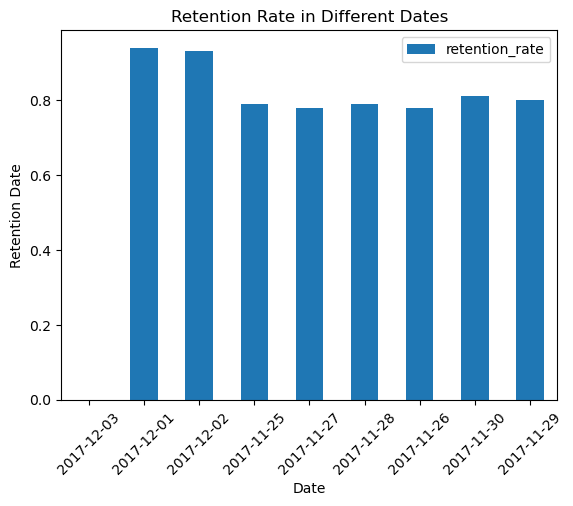

In [10]:
# Create DataFrame a (user_id, date)
raw = df.select("user_id", "date").distinct()
# raw = df.groupBy("user_id", "date").agg(col("user_id"), col("date"))

# Join DataFrames a and b on user_id and dates conditions
joined_df = raw.alias("a").join(raw.alias("b"), \
    (col("a.user_id") == col("b.user_id")) & (col("a.date") <= col("b.date")),"inner") 
#joined_df.show()

# Calculate retention_0 and retention_1 
condition0 = F.when(F.datediff(col("b.date"),col("a.date")) == 0,col("b.user_id"))
condition1 = F.when(F.datediff(col("b.date"),col("a.date")) == 1,col("b.user_id"))

temp_df = joined_df.groupBy(col("a.date")).agg(col("a.date").alias("date1"), 
                                                  F.count(condition0).alias("retention0"),
                                               F.count(condition1).alias("retention1"))

# Calculate the retention rate
retention_df = temp_df.select(col("date1").alias("date"), 
                           F.round((col("retention1")/col("retention0")),2).alias("retention_rate"))

# Data Visulization
retention_df = retention_df.toPandas()
retention_df.plot(x = 'date', y = 'retention_rate', kind = 'bar', rot=45)
plt.title('Retention Rate in Different Dates')
plt.xlabel('Date')
plt.ylabel('Retention Date')
plt.legend()
plt.show()

This graph illustrates the day-1 retention rate of users over time, where day-1 retention refers to the percentage of users who continue using the product on the day after their initial use. The graph highlights a consistently high day-1 retention rate, with notable spikes on both 2017-12-01 and 2017-12-02.

## Time Series Analysis

+----------+----------+------+-----+-----+-----+
|      date|time(hour)|    pv| cart|  fav|  buy|
+----------+----------+------+-----+-----+-----+
|2017-11-25|        00|321406|19855|11114| 6690|
|2017-11-25|        01|378673|23207|12902| 9456|
|2017-11-25|        02|437162|26749|14870|12411|
|2017-11-25|        03|432650|26286|14910|12379|
|2017-11-25|        04|424641|24956|14275|11334|
|2017-11-25|        05|470975|27398|15114|12109|
|2017-11-25|        06|479024|27974|15541|12371|
|2017-11-25|        07|503131|29478|16057|12489|
|2017-11-25|        08|496660|28994|16056|11831|
|2017-11-25|        09|460084|27652|15294|10282|
|2017-11-25|        10|464335|26794|14422| 9625|
|2017-11-25|        11|573539|32189|17344|11412|
|2017-11-25|        12|699757|40832|20651|13482|
|2017-11-25|        13|780600|47239|23243|14327|
|2017-11-25|        14|767320|48262|23962|13942|
|2017-11-25|        15|598941|41183|20594|10141|
|2017-11-25|        16|347271|20261|12328| 5383|
|2017-11-25|        

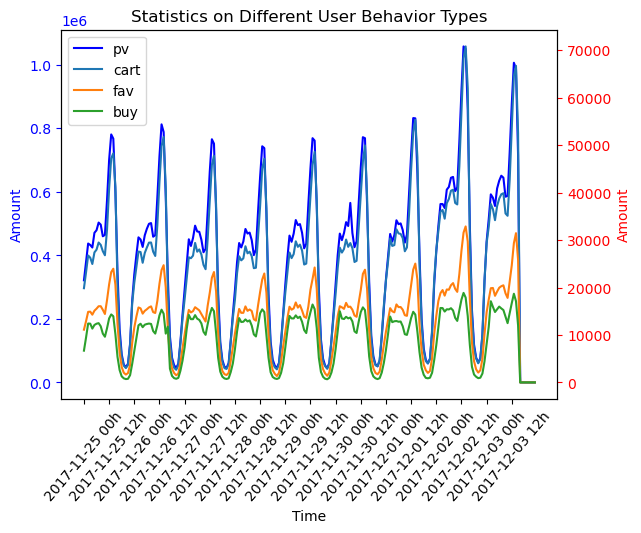

In [17]:
# User Behaviors in Different hours and dates
condition_pv = F.when(col("behavior_type")=='pv','pv')
condition_cart = F.when(col("behavior_type")=='cart','cart')
condition_fav = F.when(col("behavior_type")=='fav','fav')
condition_buy = F.when(col("behavior_type")=='buy','buy')

temp_df = df.groupBy(col("date"),col("hour").alias("time(hour)")).agg(F.count(condition_pv).alias("pv"),
                                                                      F.count(condition_cart).alias("cart"),
                                                                      F.count(condition_fav).alias("fav"),
                                                                      F.count(condition_buy).alias("buy")).orderBy(col("date"),col("hour"))
temp_df.show()

timeseries = temp_df.toPandas()
timeseries['time'] = timeseries['date'] + ' ' + timeseries['time(hour)'] + 'h'
'''
plt.plot(timeseries['time'], timeseries['pv'], label='pv')
plt.plot(timeseries['time'], timeseries['cart'], label='cart')
plt.plot(timeseries['time'], timeseries['fav'], label = 'fav')
plt.plot(timeseries['time'], timeseries['buy'], label = 'buy')

plt.xticks(timeseries['time'][::12], rotation=45)

plt.xlabel('Time')
plt.ylabel('Number of People')
plt.title('N')

# Add legend
plt.legend()

# Show the plot
plt.show()
'''
fig, ax1 = plt.subplots()
ax1.plot(timeseries['time'], timeseries['pv'], 'b-', label='pv')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amount', color='b')
ax1.tick_params('y', colors='b')
plt.xticks(timeseries['time'][::12], rotation=50)

ax2 = ax1.twinx()
ax2.plot(timeseries['time'], timeseries['cart'], label='cart')
ax2.plot(timeseries['time'], timeseries['fav'], label = 'fav')
ax2.plot(timeseries['time'], timeseries['buy'], label = 'buy')
ax2.set_ylabel('Amount', color='r')
ax2.tick_params('y', colors='r')
# ax2.set_ylim(0, 250)

plt.xticks(timeseries['time'][::12], rotation=50)
plt.title('Statistics on Different User Behavior Types')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

# Show the plot
plt.show()

This graph shows the periodic variations in user engagement across four different user behaviors. They all peak around noon, at approximately 12 PM every day. As a result, it is recommended to implement proactive operational and marketing strategies during this time window. Several actions can be effectively implemented to encourage further user engagement. These actions include advertising placement, scheduling new product launches, and conducting promotions or special offers.

## User Conversion Rate Analysis

In [12]:
Conversion_temp = df.groupBy(col("behavior_type")).agg(F.count(col("behavior_type")).alias("behavior_type_count")).orderBy(col("behavior_type"))
temp1 = Conversion_temp.collect()

## Different Types of behavior
behavior_buy = temp1[0]['behavior_type_count']
behavior_cart = temp1[1]['behavior_type_count']
behavior_fav = temp1[2]['behavior_type_count']
behavior_pv = temp1[3]['behavior_type_count']

## Calculate the sum of all different behaviors
temp2 = Conversion_temp.select(F.sum(col("behavior_type_count")).alias("behaviorSum"))
behaviorSum = temp2.collect()[0][0]

## buy rate
buy_rate = round(behavior_buy/behaviorSum,5)
## fav and cart rate
fav_cart_rate = round((behavior_cart+behavior_fav)/behaviorSum,5)

# Define the schema
schema1 = StructType([Fld("rate_name", Str(), True),
                      Fld("rate_value", Float(), True)])

# Create a DataFrame to store rate value
result_df = spark.createDataFrame([("buy_rate",buy_rate),
                                   ("fav_cart_rate",fav_cart_rate)], schema = schema1)
result_df.show()                      

+-------------+----------+
|    rate_name|rate_value|
+-------------+----------+
|     buy_rate|   0.02021|
|fav_cart_rate|    0.0841|
+-------------+----------+



The table displays the purchasing rate for various products, along with the rates of adding products to the cart and favoriting them for users.

## RFM Model

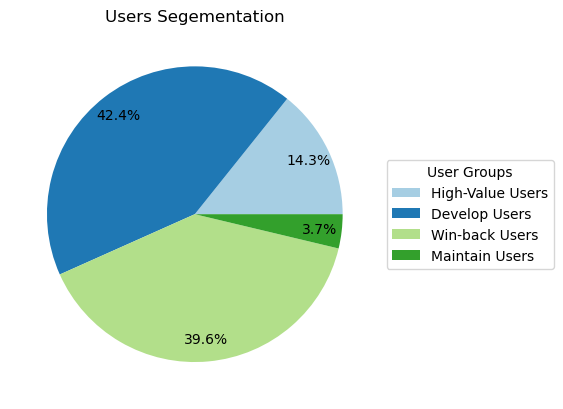

In [13]:
df_filter = df.filter(col('behavior_type')=='buy')
df_rfm = df_filter.groupBy("user_id").agg(
    col("user_id"),
    F.count(col("user_id")).alias("num_userid"),
    F.max(col("date")).alias("recent_date")
).orderBy(col("num_userid").desc(), col("recent_date").desc())

df_rfm = df_rfm.withColumn("fscore",
                           F.when((col("num_userid") >= 100) & (col("num_userid") <= 262), 5)
                           .when((col("num_userid") >= 50) & (col("num_userid") <= 99), 4)
                           .when((col("num_userid") >= 20) & (col("num_userid") <= 49), 3)
                           .when((col("num_userid") >= 5) & (col("num_userid") <= 20), 2)
                           .otherwise(1))

df_rfm = df_rfm.withColumn("rscore",
                            F.when(col("recent_date") == '2017-12-03', 5)
                            .when(col("recent_date").isin('2017-12-01', '2017-12-02'), 4)
                            .when(col("recent_date").isin('2017-11-29', '2017-11-30'), 3)
                            .when(col("recent_date").isin('2017-11-27', '2017-11-28'), 2)
                            .otherwise(1))

f_avg = df_rfm.agg(F.avg("fscore").alias("average_fscore")).collect()[0]["average_fscore"]
r_avg = df_rfm.agg(F.avg("rscore").alias("average_rscore")).collect()[0]["average_rscore"]

result_df = df_rfm.withColumn("class", 
    F.when((col("fscore") > f_avg) & (col("rscore") > r_avg), 'High-Value Users')
    .when((col("fscore") > f_avg) & (col("rscore") < r_avg), 'Maintain Users ')
    .when((col("fscore") < f_avg) & (col("rscore") > r_avg), 'Develop Users ')
    .when((col("fscore") < f_avg) & (col("rscore") < r_avg), 'Win-back Users ')
    .otherwise(None)  # or provide a default value
)

#result_df.show()

user_group_statistics = result_df.groupBy(col("class")).agg(F.count("user_id").alias("num_users"))
user_group_statistics = user_group_statistics.toPandas()

## Data Visualization
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(user_group_statistics['num_users'], labels=None, autopct='%1.1f%%', colors=plt.cm.Paired.colors, pctdistance=0.85)
# autotexts[-1].set_horizontalalignment('right')
# autotexts[-2].set_horizontalalignment('left')

### Display legend on the side
ax.legend(wedges, user_group_statistics['class'], title='User Groups', bbox_to_anchor=(1, 0.5), loc="center left")

### Add title
plt.title('Users Segementation')

### Show the plot
plt.show()

Users are divided into several groups.

## Classify the Products According to Popularity

In [14]:
category_views = df.groupBy("category_id").agg(
    F.count(F.when(col("behavior_type") == 'pv', col("behavior_type"))).alias('category_views')
).orderBy('category_views', ascending=False).limit(10)
category_views.show()

product_views = df.groupBy("item_id").agg(
    F.count(F.when(col("behavior_type") == 'pv', col("behavior_type"))).alias('product_views')
).orderBy(col('product_views'), ascending=False).limit(10)
product_views.show()

# Perform the aggregation and ranking
window_spec = Window.partitionBy("category_id").orderBy(F.desc("product&category_views"))

heatproduct_category = (df
             .groupBy(col("category_id"), col("item_id"))
             .agg(
                 F.count(F.when(col("behavior_type") == 'pv', col("behavior_type"))).alias("product&category_views"),
             )
             .withColumn("r", F.rank().over(window_spec))
             .filter(col("r") == 1)
             .orderBy(F.desc("product&category_views"))
             .limit(10))

# Show the result
heatproduct_category.show()

+-----------+--------------+
|category_id|category_views|
+-----------+--------------+
|    4756105|       4426937|
|    4145813|       3115400|
|    2355072|       3110550|
|    3607361|       2941480|
|     982926|       2763686|
|    2520377|       2003073|
|    4801426|       1841977|
|    1320293|       1769460|
|    2465336|       1484268|
|    3002561|       1406307|
+-----------+--------------+

+-------+-------------+
|item_id|product_views|
+-------+-------------+
| 812879|        29720|
|3845720|        25290|
| 138964|        20927|
|2331370|        19348|
|2032668|        19075|
|1535294|        17830|
|  59883|        17313|
|4211339|        17235|
|3371523|        17156|
|2338453|        17044|
+-------+-------------+

+-----------+-------+----------------------+---+
|category_id|item_id|product&category_views|  r|
+-----------+-------+----------------------+---+
|    4756105| 812879|                 29720|  1|
|    3607361|3845720|                 25290|  1|
|    108078

These tables show the top 10 most popular category, products and the number of product category views for each combination of category_id and item_id.

## Product Conversion Rate Analysis

In [15]:
product_conversion = (df
    .groupBy("item_id")
    .agg(
        F.count(F.when(F.col("behavior_type") == 'pv', F.col("behavior_type"))).alias("pv"),
        F.count(F.when(F.col("behavior_type") == 'fav', F.col("behavior_type"))).alias("fav"),
        F.count(F.when(F.col("behavior_type") == 'cart', F.col("behavior_type"))).alias("cart"),
        F.count(F.when(F.col("behavior_type") == 'buy', F.col("behavior_type"))).alias("buy"),
        (F.countDistinct(F.when(F.col("behavior_type") == 'buy', F.col("user_id"))) /
         F.countDistinct(F.col("user_id"))).alias("product_conversion")
    )
    .orderBy(F.desc("product_conversion"))
)

product_conversion.show()

category_conversion = (df
    .groupBy("category_id")
    .agg(
        F.count(F.when(F.col("behavior_type") == 'pv', F.col("behavior_type"))).alias("pv"),
        F.count(F.when(F.col("behavior_type") == 'fav', F.col("behavior_type"))).alias("fav"),
        F.count(F.when(F.col("behavior_type") == 'cart', F.col("behavior_type"))).alias("cart"),
        F.count(F.when(F.col("behavior_type") == 'buy', F.col("behavior_type"))).alias("buy"),
        (F.countDistinct(F.when(F.col("behavior_type") == 'buy', F.col("user_id"))) /
         F.countDistinct(F.col("user_id"))).alias("product_conversion")
    )
    .orderBy(F.desc("product_conversion"))
)

category_conversion.show()

+-------+---+---+----+---+------------------+
|item_id| pv|fav|cart|buy|product_conversion|
+-------+---+---+----+---+------------------+
|2679576|  1|  0|   0|  1|               1.0|
|3581487|  1|  0|   0|  1|               1.0|
|3450638|  3|  0|   0|  1|               1.0|
|1642356|  0|  0|   0| 11|               1.0|
|3192580|  2|  0|   0|  1|               1.0|
|3824250|  3|  0|   1|  1|               1.0|
|3699799|  0|  0|   0|  1|               1.0|
| 308325|  2|  0|   0|  1|               1.0|
|4288830|  7|  0|   0|  1|               1.0|
|3824640|  0|  0|   0|  1|               1.0|
|3722795|  4|  0|   1|  1|               1.0|
| 241733|  1|  0|   0|  1|               1.0|
|3301368|  0|  0|   0|  1|               1.0|
|3832264|  2|  0|   1|  1|               1.0|
| 991839|  2|  0|   0|  1|               1.0|
|1724244|  1|  0|   0|  1|               1.0|
|3435078|  1|  0|   0|  1|               1.0|
|1275575|  0|  0|   0|  1|               1.0|
|3832896|  1|  0|   0|  1|        

These two tables show the product conversion and category conversion rate of different user behavior types.

## User Behavior Path Analysis

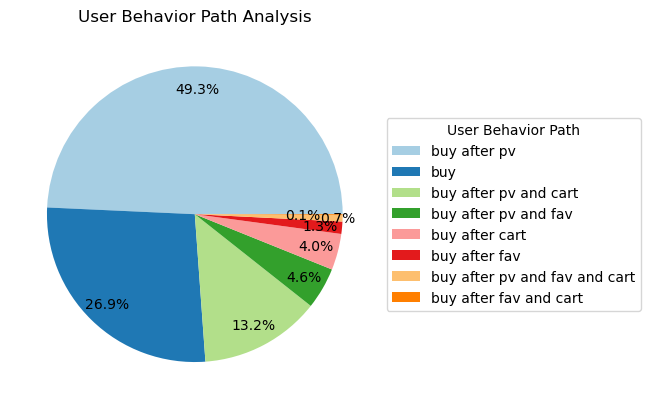

In [16]:
## "buy" behavior path types
schema2 = StructType([Fld("path_type", Str(), True),
                      Fld("description", Str(), True)])

# Create a DataFrame to store rate value
buy_behavior_path = spark.createDataFrame([('0001','buy'),
                                       ('1001','buy after pv'),
                                       ('0011','buy after cart'),
                                       ('1011','buy after pv and cart'),
                                       ('0101','buy after fav'),
                                       ('1101','buy after pv and fav'),
                                       ('0111','buy after fav and cart'),
                                       ('1111','buy after pv and fav and cart')], schema = schema2)

## users' behaviors toward different product and the number of different behaviors
condition_pv = F.when(col("behavior_type")=='pv','pv')
condition_cart = F.when(col("behavior_type")=='cart','cart')
condition_fav = F.when(col("behavior_type")=='fav','fav')
condition_buy = F.when(col("behavior_type")=='buy','buy')

user_item_behavior = df.groupBy(col("user_id"),col("item_id")).agg(F.count(condition_pv).alias("pv"),
                                                                F.count(condition_cart).alias("cart"),
                                                                F.count(condition_fav).alias("fav"),
                                                                F.count(condition_buy).alias("buy")).orderBy(col("user_id"),col("item_id"))

## mark '1' if a specific type of behaviors happens, otherwise mark '0'
condition_pv1 = (F.when(col("pv")>0,1).otherwise(0)).alias("pv")
condition_cart1 = F.when(col("cart")>0,1).otherwise(0).alias("cart")
condition_fav1 = F.when(col("fav")>0,1).otherwise(0).alias("fav")
condition_buy1 = F.when(col("buy")>0,1).otherwise(0).alias("buy")

standard_user_item = user_item_behavior.select(col("user_id"),
                                               col("item_id"),
                                               condition_pv1,
                                               condition_cart1,
                                               condition_fav1,
                                               condition_buy1)

## create user "buy" behavior path. the format looks like 'buy_behavior_path' dataframe
user_behavior_path_temp = standard_user_item.filter(col("buy") > 0).select("*", F.concat("pv","fav","cart","buy").alias("buy_behavior_path"))

## calculate the number of different types of "buy" bahavior path
user_behavior_path_count = user_behavior_path_temp.groupBy("buy_behavior_path").agg(F.count("*").alias("path_count")).orderBy(col("path_count").desc())

## join
temp_join = user_behavior_path_count.alias("u_count").join(buy_behavior_path.alias("path"), col("path.path_type") == col("u_count.buy_behavior_path"))

## calculate the number of different "buy" behavior path
path_result = temp_join.select(col("u_count.buy_behavior_path"),col("path.description"),col("u_count.path_count")).orderBy(col("u_count.path_count").desc())

## path_result.show()
path_result = path_result.toPandas()

## Data Visualization
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(path_result['path_count'], labels=None, autopct='%1.1f%%', colors=plt.cm.Paired.colors, pctdistance=0.85)
autotexts[-1].set_horizontalalignment('right')
autotexts[-2].set_horizontalalignment('left')

### Display legend on the side
ax.legend(wedges, path_result['description'], title='User Behavior Path', bbox_to_anchor=(1, 0.5), loc="center left")

### Add title
plt.title('User Behavior Path Analysis')

### Show the plot
plt.show()


As what we can see in this pie chart, most people tend to buy the products directly, buy the products after viewing the detailed information about them or buy them after add them to the shopping cart. 
Therefore, we can implement several strategies to encourage user engagement and users' shopping behaviors. The strategies include streamlined checkout process, enhanced product descriptions, cart abandonment strategies. 

1. Streamlined Checkout Process:

Optimize the checkout process to make it as seamless and straightforward as possib, which can encourage r use r to buy products directlyBesides, it's also important to Minimize the number of steps and form fields required to complete a purchse, as complex billing steps may deter users from finalizing their transactions.g

3. Enhanced Product Descriptions:

Improve the quality and clarity of product descriptions to provide detailed information. This caters to users who prefer to make informed decisions after reviewing product detail

5. Cart Abandonment Strategies:

Implement strategies to address cart abandonment. This could include sending reminder emails to users who have added products to their carts but have not completed the purchase. Consider offering incentives, such as discounts or free shipping, to encourage them to finalize their transactions.s.e.